# City2Vec

### Analyzing the Analogical Properties of Cities in Word Vector Representations

In this analysis I want to look at the properties of word vectors from city names. In the science of Natural Language Processing (NLP) there are techniques that produce word embeddings. Word embeddings create a mapping from a word or phrase to a vector of real numbers. These word embeddings are normally trained on the occurrence of words in certain contexts in larger text corpora (Wikipedia articles, official EU Documents, Social Media content). The context of a word is described based on the neighboring words in the sentence.

There have been experiments with certain word embeddings, that showed that the location of these word vectors in the vector space in relation to other word vectors can show some interesting properties similar to analogical reasoning. This analysis will build upon this observation anc see if these word vector properties can be related to geographical properties of cities in a country.

Ideally, this can be visualized using a dimensionally reduction technqiue like [Multidimensional Scaling](https://en.wikipedia.org/wiki/Multidimensional_scaling).

In [104]:
import pandas as pd
import folium
import geopy
from geopy.distance import great_circle
import gensim
import gensim.downloader as api
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pickle
import re
import scipy
from sklearn import manifold

%matplotlib inline

You can download the GloVe word vectors using the following gensim command in your terminal:

    python3 -m gensim.downloader --download "glove-wiki-gigaword-50"
    
This will then download the word vectors and store them at:

    /home/[USERNAME]/gensim-data/

In [2]:
# Load the pre-trained word vectors of the GloVe model (this takes a bit)
word_vectors = api.load("glove-wiki-gigaword-50")

In [3]:
# Load some city names of different countries

# 79 cities in the table
# src: https://en.wikipedia.org/wiki/List_of_cities_in_Germany_by_population
german_city_data = pd.read_csv("german_cities.csv", skiprows=[0]) 

# 429 cities in the table
# src: https://simple.wikipedia.org/wiki/List_of_cities_in_France
french_city_data = pd.read_csv("french_cities.csv", skiprows=[0]) 

In [4]:
def clean_city_name(city_name): 
    city_name = str(city_name).lower()
    
    # add the policy of skipping the 'le' in French city names
    # Le Mans -> Mans
    check_prefix = ['le ', 'la ']
    
    for prefix in check_prefix:
        if prefix in city_name:
            prefix_index = city_name.index(prefix) + len(prefix)
            city_name = city_name[prefix_index:]
            break

    if (' ' in str(city_name)):
        return (str(city_name).lower()[:str(city_name).index(' ')])
    else:
        return (str(city_name).lower())

german_city_data['city'] = german_city_data['City'].apply(clean_city_name)

german_city_data.head()

,2015 rank,City,State,2015 Estimate,2011 Census,Change,2015 land area,2015 population density,Location,city
0,1,Berlin,Berlin,"3,520,031","3,292,365",+6.91%,891.68 km2344.28 sq mi,"3,948/km210,230/sq mi",52°31′N 13°23′E﻿ / ﻿52.517°N 13.383°E,berlin
1,2,Hamburg,Hamburg,"1,787,408","1,706,696",+4.73%,755.3 km2291.6 sq mi,"2,366/km26,130/sq mi",53°33′N 10°0′E﻿ / ﻿53.550°N 10.000°E,hamburg
2,3,Munich (München),Bavaria,"1,450,381","1,348,335",+7.57%,310.7 km2120.0 sq mi,"4,668/km212,090/sq mi",48°8′N 11°34′E﻿ / ﻿48.133°N 11.567°E,munich
3,4,Cologne (Köln),North Rhine-Westphalia,"1,060,582","1,005,775",+5.45%,405.02 km2156.38 sq mi,"2,619/km26,780/sq mi",50°56′N 6°57′E﻿ / ﻿50.933°N 6.950°E,cologne
4,5,Frankfurt am Main,Hesse,"732,688","667,925",+9.70%,248.31 km295.87 sq mi,"2,951/km27,640/sq mi",50°7′N 8°41′E﻿ / ﻿50.117°N 8.683°E,frankfurt


Using a helper function from ["How to convert degree minute second to degree decimal in python
"](https://stackoverflow.com/questions/33997361/how-to-convert-degree-minute-second-to-degree-decimal-in-python) to convert the city coordinates to decimal degrees.

In [64]:
# convert the location column to decimal degrees format

# helper
def dms2dd(degrees, minutes, seconds, direction):
    dd = float(degrees) + float(minutes)/60 + float(seconds)/(60*60);
    if direction == 'W' or direction == 'S':
        dd *= -1
    return dd;

def clean_city_coords(city_coords): 
    city_coords = city_coords.split('/')[0]
    N,N_idx,E,E_idx = (0,0,0,0)
    
    try:
        N_idx = city_coords.index('′N')
        N = city_coords[:N_idx]
        N_dd = dms2dd(N.split('°')[0],N.split('°')[1],0,'N')
    except ValueError:
        Ns = re.split('\W+', city_coords)
        N_dd = dms2dd(Ns[0],Ns[1],Ns[2],'N')
    
    try:
        E_idx = city_coords.index('′E')
        E = city_coords[N_idx+3:E_idx]
        E_dd = dms2dd(E.split('°')[0],E.split('°')[1],0,'E')
    except ValueError:
        Es = re.split('\W+', city_coords)
        E_dd = dms2dd(Es[4],Es[5],Es[6],'E')
        
    return [N_dd,E_dd]

    

german_city_data['location_dds'] = german_city_data['Location'].apply(clean_city_coords)

In [5]:
french_city_data['city'] = french_city_data['Commune'].apply(clean_city_name)

french_city_data.head()

,Commune,Department,Region,Pop. 2013census,Rank,city
0,Paris,Paris,Île-de-France,"2,229,621",1,paris
1,Marseille,Bouches-du-Rhône,Provence-Alpes-Côte d'Azur,"855,393",2,marseille
2,Lyon,Rhône,Auvergne-Rhône-Alpes,"500,715",3,lyon
3,Toulouse,Haute-Garonne,Occitanie,"458,298",4,toulouse
4,Nice,Alpes-Maritimes,Provence-Alpes-Côte d'Azur,"342,295",5,nice


In [6]:
def construct_word_vec_dict(city_names):
    word_vec_dict = dict()
    for city in city_names:
        try:
            word_vector = word_vectors[city]
        except KeyError:
            # assign the null vector when the city name in the set of word vectors
            word_vector = np.zeros((50,), dtype=np.float32)
        
        word_vec_dict[city] = word_vector
    
    return word_vec_dict
    
german_vecs = construct_word_vec_dict(list(german_city_data['city']))
french_vecs = construct_word_vec_dict(list(french_city_data['city']))

In [7]:
print(word_vectors['paris'])
print(word_vectors['berlin'])
print(word_vectors['munich'])
print(word_vectors['stuttgart'])

[ 0.76989   1.181    -1.1299   -0.74725  -0.5969   -1.0518   -0.46552
  0.27009  -0.99243  -0.04864   0.28642  -0.75261  -1.0566   -0.19205
  0.572    -0.24391  -0.36054  -0.70876  -0.91951  -0.27024   1.5131
  1.0313   -0.55713   0.52952  -0.71494  -1.0949   -0.60565   0.31329
 -0.44488   0.55915   2.1429    0.43389  -0.5529   -0.24261  -0.43679
 -0.96014   0.25828   0.79385   0.37132   0.49623   0.84359  -0.25875
  1.5616   -1.1199    0.091676  0.076675 -0.45084  -0.86104   0.97599
 -0.35615 ]
[ 0.43801   0.78553  -0.19659  -1.3375   -0.078397 -0.37857  -0.19059
  0.31307  -0.99329  -0.50101   0.15781  -0.99817  -1.0697    0.47282
  0.5135    0.069309  0.47158  -0.094145 -0.92403   0.93513   1.6719
 -0.38873  -0.69136   0.51696  -0.28509  -1.5811   -0.43986   0.38553
 -0.97072  -0.346     1.5268    0.38354   0.15708  -0.66334  -1.3933
 -0.44692   0.80848   0.94992   0.22149   0.3744    0.47636  -0.45211
  0.48729  -1.2534    0.031507  0.35762  -0.074152 -0.098307 -0.27759
 -0.084488]

In [8]:
word_vectors['intelligence']

array([ 0.8782   , -0.45171  ,  0.96737  ,  0.040347 ,  0.76235  ,
       -0.63825  ,  0.18944  , -0.26633  ,  0.58874  , -0.93608  ,
       -0.065201 ,  0.5123   , -0.69111  ,  0.52807  , -0.71195  ,
       -0.2834   , -0.34591  ,  0.014351 ,  0.11763  ,  0.59407  ,
        0.20703  ,  0.69087  ,  1.0855   , -0.83158  , -0.35967  ,
       -2.3939   , -0.88375  , -0.417    , -0.36717  ,  0.58897  ,
        2.4132   , -0.74281  , -0.3619   , -1.9934   ,  0.093133 ,
        0.86592  , -0.75185  ,  0.19073  , -0.54284  , -0.0084839,
        0.57554  ,  0.4475   ,  0.48515  ,  0.054866 ,  0.35842  ,
       -0.51698  , -0.026014 ,  1.9907   , -0.11378  ,  0.30127  ],
      dtype=float32)

### 1st Idea : Analyze the pairwise distance of cities in the same country

Construct the distance matrix for the top 70 cities in Germany and France and compare their pairwise distances.
Apply MDS ([Multi-dimensional scaling](https://scikit-learn.org/stable/auto_examples/manifold/plot_mds.html)) to visualize the matrices in a 2 dimensional space.

In [28]:
german_vec_X = np.array([german_vecs[key] for key in german_vecs.keys()])
german_vec_y = list(german_vecs.keys())

# the element 'saale' is a zero vector, remove this before computing
idx = german_vec_y.index('(saale)')
german_vec_X = np.delete(german_vec_X, (idx), axis=0)
del german_vec_y[idx]

# construct the pairwise cosine distance matrix
cos_matrix = [[scipy.spatial.distance.cosine(german_vec_X[row], german_vec_X[col]) 
               for col in range(german_vec_X.shape[0])] for row in range(german_vec_X.shape[0])]

In [29]:
np.array(cos_matrix)

array([[0.        , 0.21688867, 0.15872866, ..., 0.73959112, 0.75459102,
        0.77005935],
       [0.21688867, 0.        , 0.1015175 , ..., 0.58111277, 0.6614342 ,
        0.71357739],
       [0.15872866, 0.1015175 , 0.        , ..., 0.66412744, 0.67875588,
        0.72720835],
       ...,
       [0.73959112, 0.58111277, 0.66412744, ..., 0.        , 0.51101431,
        0.62263399],
       [0.75459102, 0.6614342 , 0.67875588, ..., 0.51101431, 0.        ,
        0.50285265],
       [0.77005935, 0.71357739, 0.72720835, ..., 0.62263399, 0.50285265,
        0.        ]])

In [34]:
mds_embedding = manifold.MDS(n_components=2, dissimilarity='precomputed')
german_vec_mds = mds_embedding.fit_transform(cos_matrix)

In [35]:
german_vec_mds[:5]

array([[ 0.11437608,  0.43664136],
       [-0.03294587,  0.33901954],
       [-0.07126341,  0.38632956],
       [-0.07844811,  0.20340114],
       [-0.04650305,  0.43153408]])

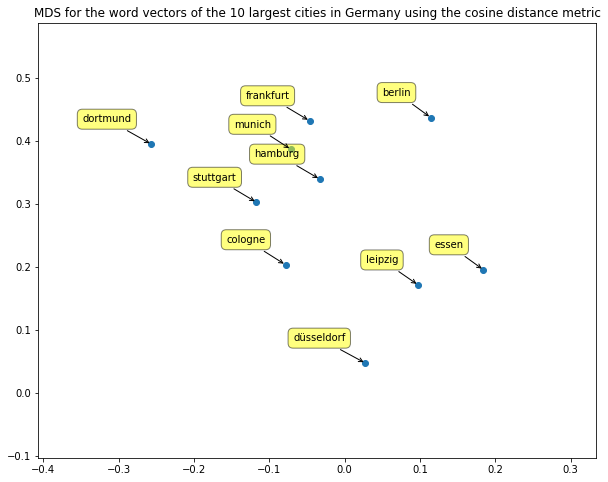

In [103]:
TOP_N = 10

plt.figure(figsize=(10,8))
plt.scatter(german_vec_mds[:TOP_N, 0], german_vec_mds[:TOP_N, 1], marker='o', cmap=plt.get_cmap('Spectral'))
plt.xlim(min(german_vec_mds[:TOP_N, 0])-0.15,max(german_vec_mds[:TOP_N, 0])+0.15)
plt.ylim(min(german_vec_mds[:TOP_N, 1])-0.15,max(german_vec_mds[:TOP_N, 1])+0.15)
plt.title("MDS for the word vectors of the {0} largest cities in Germany using the cosine distance metric".format(TOP_N))

for label, x, y in zip(list(german_vec_y)[:TOP_N], german_vec_mds[:TOP_N, 0], german_vec_mds[:TOP_N, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

plt.show()

Let's compare this to the MDS map created by taking the [great circle distance](https://en.wikipedia.org/wiki/Great-circle_distance) between each of the top 10 German cities.

In [73]:
german_city_data.head(n=2)

,2015 rank,City,State,2015 Estimate,2011 Census,Change,2015 land area,2015 population density,Location,city,location_dds
0,1,Berlin,Berlin,"3,520,031","3,292,365",+6.91%,891.68 km2344.28 sq mi,"3,948/km210,230/sq mi",52°31′N 13°23′E﻿ / ﻿52.517°N 13.383°E,berlin,"[52.516666666666666, 13.383333333333333]"
1,2,Hamburg,Hamburg,"1,787,408","1,706,696",+4.73%,755.3 km2291.6 sq mi,"2,366/km26,130/sq mi",53°33′N 10°0′E﻿ / ﻿53.550°N 10.000°E,hamburg,"[53.55, 10.0]"


In [80]:
berlin_coords = german_city_data['location_dds'][0]
hamburg_coords = german_city_data['location_dds'][1]
great_circle(berlin_coords,hamburg_coords).kilometers

253.70450393611705

In [84]:
german_locs = german_city_data['location_dds']
# construct the pairwise great circle distance matrix
great_circle_matrix = np.array([[great_circle(german_locs[row], german_locs[col]).kilometers 
               for col in range(len(german_locs))] for row in range(len(german_locs))])

mds_embedding = manifold.MDS(n_components=2, dissimilarity='precomputed')
german_circle_dist_mds = mds_embedding.fit_transform(great_circle_matrix)

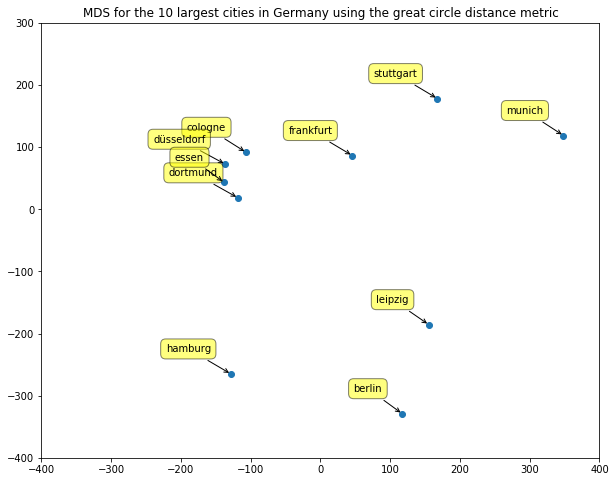

In [91]:
plt.figure(figsize=(10,8))
plt.scatter(german_circle_dist_mds[:10, 0], german_circle_dist_mds[:10, 1], marker='o', cmap=plt.get_cmap('Spectral'))
plt.xlim(-400,400)
plt.ylim(-400,300)
plt.title("MDS for the 10 largest cities in Germany using the great circle distance metric")

for label, x, y in zip(list(german_vec_y)[:10], german_circle_dist_mds[:10, 0], german_circle_dist_mds[:10, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

plt.show()